Dataset samples: 885
Loaded pretrained weights. Skipping training.
Test Loss: 0.0022


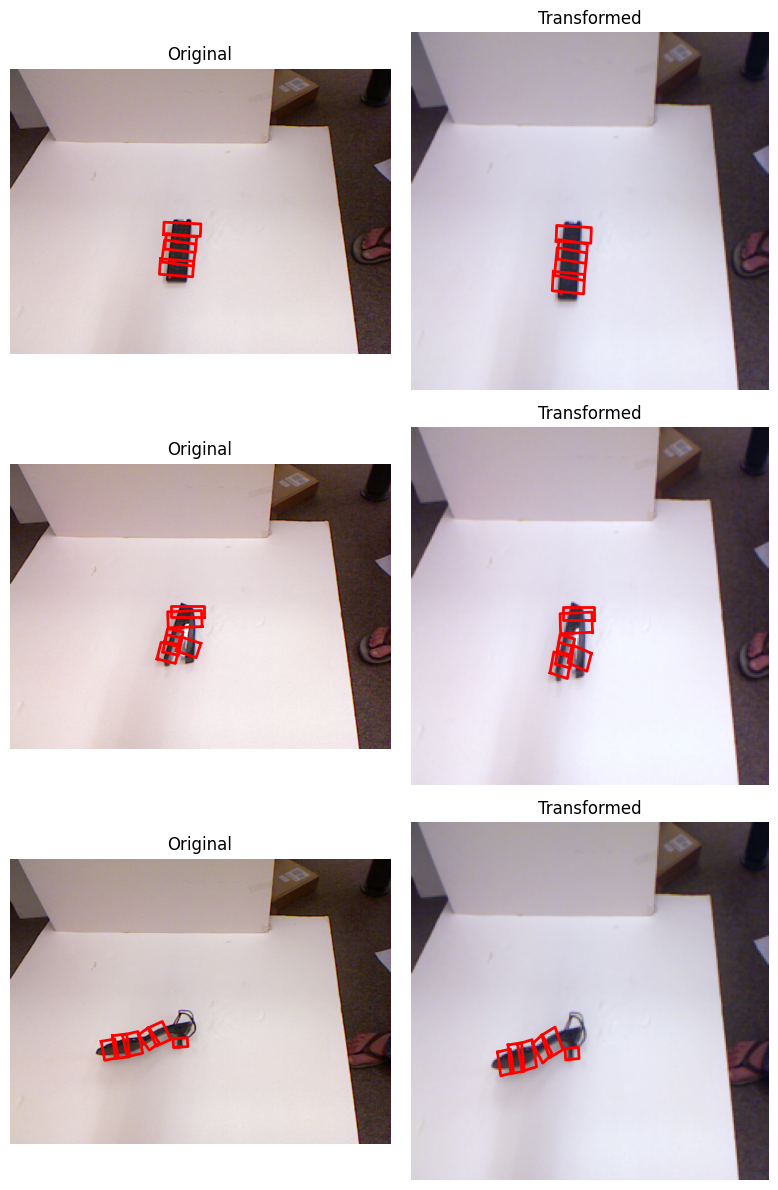

Predicted grasp box (pixel coordinates):
[[241.59537 310.6186 ]
 [306.32712 310.6186 ]
 [306.32712 345.21234]
 [241.59537 345.21234]]
Loaded pretrained GRConvNet weights.
>>> STARTING SCRIPT, CONNECTING PYBULLET <<<
Using EE link index: 11


>>> ENTERING DQN TRAINING LOOP (HEADLESS) <<<


=== Starting Episode 0 ===
[EP 0] Predicted grasp pixel coords: [[134.70749   70.783966]
 [154.06296   70.783966]
 [154.06296  172.5537  ]
 [134.70749  172.5537  ]]
>>> Resetting env with target_pos: [0.5433730670383998, 0.012949337278093609, 0.08] target_yaw: 0.0
Step 1, action 3
Step 2, action 4
Step 3, action 8
Step 4, action 8
Step 5, action 1
Step 6, action 3
Step 7, action 2
Step 8, action 7
Step 9, action 8
Step 10, action 2
Step 11, action 7
Step 12, action 4
Step 13, action 7
Step 14, action 9
Step 15, action 3
Step 16, action 5
Step 17, action 4
Step 18, action 6
Step 19, action 1
Step 20, action 9
Step 21, action 0
Step 22, action 5
Step 23, action 1
Step 24, action 6
Step 25, action 0
Step

In [2]:
import math
import os
import random
from collections import deque

import pybullet as p
import pybullet_data
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from datasetOne import GRConvNet, denormalize_grasp


# ===== LOAD PRETRAINED GRC0NVNET =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRConvNet().to(device)
weights_path = "grconvnet_weights.pth"
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    print("Loaded pretrained GRConvNet weights.")
else:
    raise FileNotFoundError(f"{weights_path} not found!")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def predict_grasp(pil_image):
    img = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img)[0].cpu()
    return denormalize_grasp(out)  # (4,2) pixel coords


# ===== GRASP UTILITIES =====
def grasp_center_and_angle(grasp_box):
    """
    grasp_box: (4,2) pixel coords.
    Returns: center_x, center_y, angle (radians).
    """
    cx = float(np.mean(grasp_box[:, 0]))
    cy = float(np.mean(grasp_box[:, 1]))
    dx = float(grasp_box[1, 0] - grasp_box[0, 0])
    dy = float(grasp_box[1, 1] - grasp_box[0, 1])
    angle = math.atan2(dy, dx)
    return cx, cy, angle

def pixel_to_world(px, py, img_width=224, img_height=224,
                   table_center=(0.5, 0.0), scale=0.3):
    """
    Rough mapping from image pixel (px,py) to world XY.
    Tune `scale` and `table_center` for your setup.
    """
    x = table_center[0] + (px - img_width / 2.0) / img_width * scale
    y = table_center[1] + (py - img_height / 2.0) / img_height * scale
    return x, y


# ===== DQN NETWORK =====
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


# ===== REPLAY BUFFER =====
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, ns, d):
        self.buffer.append((s, a, r, ns, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, ns, d = zip(*batch)
        return (
            torch.tensor(np.array(s), dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.int64, device=device),
            torch.tensor(r, dtype=torch.float32, device=device),
            torch.tensor(np.array(ns), dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)


# ===== RL ENVIRONMENT AROUND PYBULLET + PANDA =====
class RLGraspEnv:
    """
    State: [dx, dy, dz, yaw_err, gripper_open]
    Actions:
      0: +x, 1: -x, 2: +y, 3: -y, 4: +z, 5: -z
      6: +yaw, 7: -yaw, 8: close gripper, 9: open gripper
    """
    def __init__(self, robot, cube, arm_joints, finger_joints,
                 ee_link_name="panda_grasptarget"):
        self.robot = robot
        self.cube = cube
        self.arm_joints = arm_joints
        self.finger_joints = finger_joints

        self.delta_pos = 0.01
        self.delta_yaw = 0.05
        self.max_steps = 80

        self.ee_link_index = self._find_ee_link(ee_link_name)
        print("Using EE link index:", self.ee_link_index)

        self.state_dim = 5
        self.action_dim = 10

        self.step_count = 0
        self.gripper_open = 0.04  # meters

        self.target_pos = None
        self.target_yaw = None

    def _find_ee_link(self, name_hint):
        n_joints = p.getNumJoints(self.robot)
        for i in range(n_joints):
            link_name = p.getJointInfo(self.robot, i)[12].decode()
            if name_hint in link_name:
                return i
        return n_joints - 1

    def _set_gripper(self, opening):
        opening = float(np.clip(opening, 0.0, 0.08))
        pos_each = opening / 2.0
        for j in self.finger_joints:
            p.setJointMotorControl2(self.robot, j, p.POSITION_CONTROL,
                                    targetPosition=pos_each, force=20)

    def _get_ee_pose(self):
        state = p.getLinkState(self.robot, self.ee_link_index)
        pos = np.array(state[0])
        yaw = p.getEulerFromQuaternion(state[1])[2]
        return pos, yaw

    def _ik_to(self, pos, yaw):
        roll = math.pi
        pitch = 0.0
        q = p.getQuaternionFromEuler([roll, pitch, yaw])
        sol = p.calculateInverseKinematics(
            self.robot, self.ee_link_index, pos, q,
            maxNumIterations=200
        )
        for idx, joint in enumerate(self.arm_joints):
            p.setJointMotorControl2(self.robot, joint, p.POSITION_CONTROL,
                                    targetPosition=sol[idx], force=200)

    def _compute_state(self):
        ee_pos, ee_yaw = self._get_ee_pose()
        dx, dy, dz = self.target_pos - ee_pos
        yaw_err = self.target_yaw - ee_yaw
        yaw_err = (yaw_err + math.pi) % (2 * math.pi) - math.pi
        return np.array([dx, dy, dz, yaw_err, self.gripper_open],
                        dtype=np.float32)

    def reset_robot(self):
        home = [0.0, -0.3, 0.0, -2.2, 0.0, 2.0, 0.8]
        for j, val in zip(self.arm_joints, home):
            p.resetJointState(self.robot, j, val)
        self.gripper_open = 0.04
        self._set_gripper(self.gripper_open)
        for _ in range(20):
            p.stepSimulation()

    def reset(self, target_pos, target_yaw):
        print(">>> Resetting env with target_pos:", target_pos,
              "target_yaw:", target_yaw)
        self.reset_robot()
        self.target_pos = np.array(target_pos, dtype=np.float32)
        self.target_yaw = float(target_yaw)
        self.step_count = 0
        return self._compute_state()

    def step(self, action):
        self.step_count += 1
        print(f"Step {self.step_count}, action {action}")

        ee_pos, ee_yaw = self._get_ee_pose()
        new_pos = ee_pos.copy()
        new_yaw = ee_yaw

        # motion actions 0–7
        if action == 0:   new_pos[0] += self.delta_pos
        elif action == 1: new_pos[0] -= self.delta_pos
        elif action == 2: new_pos[1] += self.delta_pos
        elif action == 3: new_pos[1] -= self.delta_pos
        elif action == 4: new_pos[2] += self.delta_pos
        elif action == 5: new_pos[2] -= self.delta_pos
        elif action == 6: new_yaw += self.delta_yaw
        elif action == 7: new_yaw -= self.delta_yaw

        # gripper 8–9
        if action == 8:
            self.gripper_open -= 0.01
        elif action == 9:
            self.gripper_open += 0.01

        self.gripper_open = float(np.clip(self.gripper_open, 0.0, 0.08))
        self._set_gripper(self.gripper_open)

        new_pos[2] = float(np.clip(new_pos[2], 0.05, 0.4))

        if action <= 7:
            self._ik_to(new_pos, new_yaw)

        for _ in range(8):
            p.stepSimulation()

        next_state = self._compute_state()
        ee_pos, _ = self._get_ee_pose()
        dist = float(np.linalg.norm(self.target_pos - ee_pos))

        reward = -dist - 0.01
        done = False
        success = False

        cube_pos, _ = p.getBasePositionAndOrientation(self.cube)
        cube_pos = np.array(cube_pos)
        if self.gripper_open < 0.015 and cube_pos[2] > 0.1:
            reward += 5.0
            done = True
            success = True

        if self.step_count >= self.max_steps:
            done = True

        return next_state, reward, done, {"success": success}


# ===== MAIN (HEADLESS BY DEFAULT) =====
def main(gui=False, train_dqn=True):
    print(">>> STARTING SCRIPT, CONNECTING PYBULLET <<<")

    cid = p.connect(p.GUI if gui else p.DIRECT)
    if cid < 0:
        raise RuntimeError("Could not connect to PyBullet")

    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setGravity(0, 0, -9.81)
    p.setRealTimeSimulation(0)

    # world + robot
    p.loadURDF("plane.urdf")
    table = p.loadURDF("table/table.urdf", [0.5, 0.0, -0.65],
                       p.getQuaternionFromEuler([0, 0, 0]))
    cube = p.loadURDF("cube_small.urdf", [0.5, 0.0, 0.02])
    robot = p.loadURDF("franka_panda/panda.urdf", [0, 0, 0],
                       useFixedBase=True)

    # joints
    nJ = p.getNumJoints(robot)
    joint_name_to_index = {
        p.getJointInfo(robot, i)[1].decode(): i
        for i in range(nJ)
    }
    arm_joints = [joint_name_to_index[f"panda_joint{i}"] for i in range(1, 8)]
    finger_joints = [i for i in range(nJ)
                     if "finger" in p.getJointInfo(robot, i)[1].decode()]

    # camera function (TinyRenderer for headless)
    def get_image():
        width, height, rgb, depth, seg = p.getCameraImage(
            width=224, height=224,
            viewMatrix=p.computeViewMatrixFromYawPitchRoll(
                cameraTargetPosition=[0.5, 0.0, 0.0],
                distance=1.0, yaw=60, pitch=-35, roll=0,
                upAxisIndex=2
            ),
            projectionMatrix=p.computeProjectionMatrixFOV(
                fov=60, aspect=1.0, nearVal=0.1, farVal=2.0
            ),
            renderer=p.ER_TINY_RENDERER  # headless-friendly
        )
        rgb = np.array(rgb, dtype=np.uint8).reshape((height, width, 4))[:, :, :3]
        return Image.fromarray(rgb)

    env = RLGraspEnv(robot, cube, arm_joints, finger_joints)

    state_dim = env.state_dim
    action_dim = env.action_dim

    dqn = DQN(state_dim, action_dim).to(device)
    target_dqn = DQN(state_dim, action_dim).to(device)
    target_dqn.load_state_dict(dqn.state_dict())

    replay = ReplayBuffer(capacity=50_000)
    optimizer = optim.Adam(dqn.parameters(), lr=1e-3)

    gamma = 0.99
    batch_size = 64
    epsilon_start = 1.0
    epsilon_final = 0.05
    epsilon_decay = 50_000
    global_step = 0

    def epsilon_fn(step):
        return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-step / epsilon_decay)

    def select_action(state, eps):
        if random.random() < eps:
            return random.randrange(action_dim)
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q = dqn(s)
            return int(q.argmax(dim=1).item())

    def optimize():
        if len(replay) < 1_000:
            return
        states, actions, rewards, next_states, dones = replay.sample(batch_size)
        q_values = dqn(states)
        q_sa = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q = target_dqn(next_states)
            next_q_max = next_q.max(1)[0]
            target = rewards + gamma * (1 - dones) * next_q_max

        loss = nn.functional.mse_loss(q_sa, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ===== TRAINING LOOP =====
    if train_dqn:
        print("\n\n>>> ENTERING DQN TRAINING LOOP (HEADLESS) <<<\n")

        num_episodes = 300  # adjust as needed

        for ep in range(num_episodes):
            print(f"\n=== Starting Episode {ep} ===")

            # randomise cube position a bit
            x = 0.5 + 0.1 * (random.random() - 0.5)
            y = 0.0 + 0.1 * (random.random() - 0.5)
            p.resetBasePositionAndOrientation(
                cube, [x, y, 0.02],
                p.getQuaternionFromEuler([0, 0, 0])
            )

            # camera & grasp prediction
            pil_image = get_image()
            grasp_box = predict_grasp(pil_image)
            grasp_box = np.clip(grasp_box, 0, 223)
            print(f"[EP {ep}] Predicted grasp pixel coords: {grasp_box}")

            cx, cy, angle = grasp_center_and_angle(grasp_box)
            gx, gy = pixel_to_world(cx, cy, img_width=224, img_height=224,
                                    table_center=(0.5, 0.0), scale=0.3)
            cube_pos, _ = p.getBasePositionAndOrientation(cube)
            gz = cube_pos[2] + 0.06  # just above cube

            target_pos = [gx, gy, gz]
            target_yaw = angle

            state = env.reset(target_pos, target_yaw)
            done = False
            ep_reward = 0.0

            while not done:
                eps = epsilon_fn(global_step)
                action = select_action(state, eps)
                next_state, reward, done, info = env.step(action)

                replay.push(state, action, reward, next_state, float(done))
                state = next_state
                ep_reward += reward
                global_step += 1

                optimize()

                if global_step % 1_000 == 0:
                    target_dqn.load_state_dict(dqn.state_dict())

            print(f"Episode {ep} | Reward = {ep_reward:.3f} | Success = {info['success']}")

    # If you want to just watch behaviour later:
    if gui and not train_dqn:
        print(">>> GUI mode: stepping simulation forever (no training) <<<")
        while True:
            p.stepSimulation()

    p.disconnect()


if __name__ == "__main__":
    # Headless training by default
    main(gui=False, train_dqn=True)
